In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from ipywidgets import interactive
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Reading CSVs
~ ecs_updated (becomes ecs) - includes funding details for all 50 states + DC (needs to be merged on State)

~ enrollment_changes (becomes enrollments) - includes calculations for annual enrollment changes by NCES ID (filtered to local districts not affiliated with a supervisory union only and only includes columns needed for the loop or for merging, can be merged on State with ECS data or on NCES ID for other sources)

~ localdistricts (becomes localdistricts) - does not include enrollment change calculations, but does still include columns for locale, ZIP code, FTE count, pupil/teacher ratio, and year (can be merged on NCES ID or State depending on the need, shape aligns exactly to enrollment_changes)

~ enrollmentsdf (becomes fullnces) - primary dataframe until the loop; contains all columns and rows so it may ultimately prove to need more cleaning and restructuring than is helpful (can be merged by state or NCES ID)

In [ ]:
ecs = pd.read_csv("../data/ecs_updated.csv")
ecs.head(3)

In [ ]:
enrollments = pd.read_csv("../data/enrollment_changes.csv")
enrollments.head(3)

In [ ]:
localdistricts = pd.read_csv("../data/localdistricts.csv")
localdistricts.head(3)

In [ ]:
#unlikely to use, but here for reference as needed
fullnces = pd.read_csv("../data/enrollmentsdf.csv")
fullnces.head(3)

In [ ]:
netchangedist = enrollments.groupby(['State Name', 'Agency Name', 'NCES ID'])['Enrollment Change'].sum().reset_index()
netchangedist.head()

## Cleaning & Standardizing DataFrames

In [ ]:
ecs = ecs.drop("Unnamed: 0", axis=1)
ecs.head(2)

In [ ]:
ecs.rename(columns={'State':'State Name'}, inplace=True)
ecs.head(1)

In [ ]:
enrollments = enrollments.drop("Unnamed: 0", axis=1)
enrollments.head(2)

In [ ]:
netchangedist.rename(columns={'Enrollment Change':'Net Enrollment Change'}, inplace=True)
netchangedist.head(2)

## Merging DataFrames
Will also include dropping duplicate/unnecessary columns, standardizing column names, and reordering columns for efficiency.

In [ ]:
netenrollments = enrollments.merge(netchangedist, on='NCES ID', suffixes=('_nces', '_net'))
netenrollments.head(3)

In [ ]:
netenrollments.rename(columns={'Agency Name_nces':'Agency Name', 'State Name_nces':'State Name', 'Enrollment Change_nces':'Annual Enrollment Change', 'Enrollment Change_net':'Net Enrollment Change'}, inplace=True)
netenrollments.head(3)

In [ ]:
netenrollments = netenrollments.drop(['State Name_net', 'Agency Name_net'], axis=1)
netenrollments.head(3)

In [ ]:
enrollments.shape

In [ ]:
netchangedist.shape

In [ ]:
netenrollments.shape

In [ ]:
localdistricts.shape

In [ ]:
netandlocal = localdistricts.merge(netenrollments, on=['NCES ID', 'Year'], how='left', suffixes=('_loc', '_net'))
netandlocal.shape
#dataframes were the same shape - needed left merge rather than outer to avoid 8x duplicates

In [ ]:
netandlocal.head(3)

In [ ]:
netandlocal = netandlocal.drop(['Student Count_loc', 'Agency Name', 'District', 'State me'], axis=1)
netandlocal.head(3)

In [ ]:
netandlocal.rename(columns={'Agency me':'Agency Name', 'State me':'State Name', 'Student Count_net':'Student Count'}, inplace=True)
netandlocal.head(3)

In [ ]:
netandlocal.shape

In [ ]:
netfunding = netandlocal.merge(ecs, on='State Name', how='outer', suffixes=('_net', '_ecs'))
netfunding.shape

In [ ]:
netfunding.info()
#all rows should have a state name given the df shape and non-null count

In [ ]:
netfunding.head(2)

In [ ]:
#netfunding.to_csv("../data/netfunding.csv")

In [ ]:
#netandlocal.to_csv("../data/netandlocal2.csv")

In [ ]:
#netenrollments.to_csv("../data/netenrollments.csv")

## Additional DataFrames & Cleaning

In [2]:
data = pd.read_csv("../data/netfunding.csv")
data.shape

C:\Users\cbrown\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (21,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(104923, 58)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104923 entries, 0 to 104922
Data columns (total 58 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   Unnamed: 0                                            104923 non-null  int64  
 1   Agency Name                                           104922 non-null  object 
 2   State Abbreviation                                    104922 non-null  object 
 3   NCES ID                                               104922 non-null  float64
 4   County                                                104898 non-null  object 
 5   School Count                                          104922 non-null  float64
 6   ZIP Code                                              104922 non-null  float64
 7   District Type                                         104922 non-null  float64
 8   Locale                                      

In [4]:
data.head(2)

,Unnamed: 0,Agency Name,State Abbreviation,NCES ID,County,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Year,State Name,Student Count,Enrollment Change,Net Enrollment Change,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source,Census Region,2020 Election Result,2020 Battleground State
0,0,ALABAMA YOUTH SERVICES,AL,100002.0,MONTGOMERY COUNTY,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,2013.0,ALABAMA,NaN,NaN,0.0,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN,South,Republican,No
1,1,ALABAMA YOUTH SERVICES,AL,100002.0,JEFFERSON COUNTY,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,2014.0,ALABAMA,NaN,NaN,0.0,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN,South,Republican,No


In [5]:
data = data.drop(['Unnamed: 0'], axis=1)
data.head(1)

,Agency Name,State Abbreviation,NCES ID,County,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Year,State Name,Student Count,Enrollment Change,Net Enrollment Change,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source,Census Region,2020 Election Result,2020 Battleground State
0,ALABAMA YOUTH SERVICES,AL,100002.0,MONTGOMERY COUNTY,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,2013.0,ALABAMA,NaN,NaN,0.0,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN,South,Republican,No


In [7]:
cols = list(data.columns.values)
cols

['Agency Name',
 'State Abbreviation',
 'NCES ID',
 'County',
 'School Count',
 'ZIP Code',
 'District Type',
 'Locale',
 'Start of Year Status',
 'Updated Status',
 'FTE Teachers',
 'Pupil/Teacher Ratio',
 'Total Staff',
 'Year',
 'State Name',
 'Student Count',
 'Enrollment Change',
 'Net Enrollment Change',
 'Primary Funding Model',
 'Model Name',
 'Notes',
 'Base Amount (Y/N)',
 'Base Amount',
 'Base Amount Legal Source',
 'Student Count Method',
 'Student Count Method Source',
 'Special Education Funding Mechanism',
 'Special Education Program Name',
 'Special Education Amount (Dollar amount or weight)',
 'Is there a Cap or Minimum threshold in place?',
 'Special Education Funding Description',
 'Special Education Funding Source',
 'English Learner Funding? (Y/N)',
 'English Learner Funding Mechanism',
 'English Learner Program Name',
 'English Learner Amount (Dollar amount or weight)',
 'ELL Amount Source',
 'At-Risk Funding for Low-Income Students (Y/N)',
 'Low-Income Students F

In [8]:
cols = ['Agency Name', 'State Name', 'State Abbreviation', 'NCES ID', 'County', 'Student Count', 'Year', 'Enrollment Change', 'Net Enrollment Change', 'School Count', 'ZIP Code', 'District Type', 'Locale', 'Start of Year Status', 'Updated Status', 'FTE Teachers', 'Pupil/Teacher Ratio', 'Total Staff', 'Census Region', '2020 Election Result', '2020 Battleground State', 'Primary Funding Model', 'Model Name', 'Notes', 'Base Amount (Y/N)', 'Base Amount', 'Base Amount Legal Source', 'Student Count Method', 'Student Count Method Source', 'Special Education Funding Mechanism', 'Special Education Program Name', 'Special Education Amount (Dollar amount or weight)', 'Is there a Cap or Minimum threshold in place?', 'Special Education Funding Description', 'Special Education Funding Source', 'English Learner Funding? (Y/N)', 'English Learner Funding Mechanism', 'English Learner Program Name', 'English Learner Amount (Dollar amount or weight)', 'ELL Amount Source', 'At-Risk Funding for Low-Income Students (Y/N)', 'Low-Income Students Funding Mechanism', 'Low-Income Students Program Name', 'Low-Income Students Identifier', 'Low-Income Students Amount (Dollar amount or weight)', 'Low-Income Funding Source', 'Gifted and Talented Funding? (Y/N)', 'Gifted and Talented Funding Mechanism', 'Gifted and Talented Program Name', 'Gifted and Talented Amount (Dollar amount or weight)', 'Gifted Funding Source', 'Small Size or Isolated Adjustment? (Y/N)', 'Small Size Funding Mechanism', 'Small Size Program Name', 'Small Size Amount (Dollar amount or weight)', 'Small Size Identifier', 'Small Size Identifier Source']

In [9]:
data = data[cols]
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.0,MONTGOMERY COUNTY,NaN,2013.0,NaN,0.0,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002.0,JEFFERSON COUNTY,NaN,2014.0,NaN,0.0,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


In [10]:
data['NCES ID'] = data['NCES ID'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,MONTGOMERY COUNTY,NaN,2013.0,NaN,0.0,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,JEFFERSON COUNTY,NaN,2014.0,NaN,0.0,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


In [11]:
data['Year'] = data['Year'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,MONTGOMERY COUNTY,NaN,2013,NaN,0.0,7.0,36057.0,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,JEFFERSON COUNTY,NaN,2014,NaN,0.0,6.0,36057.0,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


In [12]:
data['ZIP Code'] = data['ZIP Code'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,MONTGOMERY COUNTY,NaN,2013,NaN,0.0,7.0,36057,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,JEFFERSON COUNTY,NaN,2014,NaN,0.0,6.0,36057,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


In [13]:
data['Net Enrollment Change'] = data['Net Enrollment Change'].astype(str).str.replace('.0', '', regex=False)
data.head(2)

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
0,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,MONTGOMERY COUNTY,NaN,2013,NaN,0,7.0,36057,1.0,21-Suburb: Large,1-Open,NaN,0.0,NaN,0.0,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN
1,ALABAMA YOUTH SERVICES,ALABAMA,AL,100002,JEFFERSON COUNTY,NaN,2014,NaN,0,6.0,36057,1.0,41-Rural: Fringe,1-Open,1-Open,NaN,NaN,NaN,South,Republican,No,Resource-based allocation,Foundation Program,NaN,No,NaN,NaN,Membership average,Ala. Code § 16-13-232,Hybrid - census-based and high-cost services f...,Foundation Program and Catastrophic Trust Fund...,Census-based funding - the adjustment for spec...,"Yes, census-based cap of 5% ADM.",The Foundation Program adjusts ADM assuming 5%...,Ala. Admin. Code 290-2-1-.01 Ala. Code § 16-39-30,Yes,Categorical grant,English Language Learners Program,"Grant of $14,155,334 (2021-2022) to districts",Act 2021-342 (2021-2022 enacted budget),Yes,Categorical grant,At-Risk Student Program,Multiple - reduced or free - National School L...,"Provides $19,517,734 (2021-2022) for the program.",Ala. Admin. Code 290-2-1-.05 SB 189 (Budget bi...,Yes,Categorical grant,Gifted Students Program,"Total state appropriation of $4,825,000 FY2022",Ala. Code § 16-1-51 - amount in FY 2022 budget,No,NaN,NaN,NaN,NaN,NaN


In [14]:
data['Net Enrollment Change'] = pd.to_numeric(data['Net Enrollment Change'], errors='coerce')
data['Net Enrollment Change'].dtype

dtype('float64')

In [18]:
sbfdn = data.loc[data['Primary Funding Model'] == 'Student-based foundation']

In [19]:
rbased = data.loc[data['Primary Funding Model'] == 'Resource-based allocation']

In [20]:
hybrid = data.loc[data['Primary Funding Model'] == 'Hybrid']

In [21]:
gtbase = data.loc[data['Primary Funding Model'] == 'Guaranteed tax base']

In [22]:
baseamt = data.loc[data['Base Amount (Y/N)'] == 'Yes']

In [23]:
nbaseamt = data.loc[data['Base Amount (Y/N)'] == 'No']

In [24]:
northeast = data.loc[data['Census Region'] == 'Northeast']

In [25]:
midwest = data.loc[data['Census Region'] == 'Midwest']

In [26]:
south = data.loc[data['Census Region'] == 'South']

In [27]:
west = data.loc[data['Census Region'] == 'West']

In [28]:
republican = data.loc[data['2020 Election Result'] == 'Republican']

In [29]:
democrat = data.loc[data['2020 Election Result'] == 'Democrat']

In [30]:
batlgrnd = data.loc[data['2020 Battleground State'] == 'Yes']

In [31]:
nbatlgrnd = data.loc[data['2020 Battleground State'] == 'No']

In [32]:
year13 = data.loc[data['Year'] == '2013']

In [33]:
year14 = data.loc[data['Year'] == '2014']

In [34]:
year15 = data.loc[data['Year'] == '2015']

In [35]:
year16 = data.loc[data['Year'] == '2016']

In [36]:
year17 = data.loc[data['Year'] == '2017']

In [37]:
year18 = data.loc[data['Year'] == '2018']

In [38]:
year19 = data.loc[data['Year'] == '2019']

In [39]:
year20 = data.loc[data['Year'] == '2020']

In [48]:
top25g1 = data.nlargest(200, "Net Enrollment Change", keep='last')
top25g1
#running with 200 because variable numbers within each row keep them from being seen as duplicates. Next step is drop the unneeded columns, then drop dupes, and then rename the df for usability

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
91439,FRISCO ISD,TEXAS,TX,4820010,Collin County,63493.0,2020,788.0,17440.0,74.0,75035,1.0,21-Suburb: Large,1-Open,1-Open,4389.0,14.0,7620.0,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,$6160 (2020-2023),Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,Multiple student weights,Student-Based Allotments: Special Education,Additional weights range from 1.1 to 5.0 Mains...,No,Different student weights are based on where t...,Tex. Educ. Code Ann. § 48.102,Yes,Multiple student weights,Bilingual Education Allotment,Additional weight of .1 for a student of limit...,Tex. Educ. Code Ann. § 48.105,Yes,Multiple student weights,Compensatory Education Allotment,Multiple - the state has an index for economic...,Provides the following weights in five tiers r...,Tex. Educ. Code Ann. § 48.104,No,NaN,NaN,NaN,NaN,Yes,Multiple student weights,Small and Mid-Sized District Allotment,"For small districts (those with fewer than 1,6...",Number of students,Tex. Educ. Code Ann. § 48.101
91438,FRISCO ISD,TEXAS,TX,4820010,Collin County,62705.0,2019,2523.0,17440.0,73.0,75035,1.0,21-Suburb: Large,1-Open,1-Open,4279.0,15.0,7400.0,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,$6160 (2020-2023),Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,Multiple student weights,Student-Based Allotments: Special Education,Additional weights range from 1.1 to 5.0 Mains...,No,Different student weights are based on where t...,Tex. Educ. Code Ann. § 48.102,Yes,Multiple student weights,Bilingual Education Allotment,Additional weight of .1 for a student of limit...,Tex. Educ. Code Ann. § 48.105,Yes,Multiple student weights,Compensatory Education Allotment,Multiple - the state has an index for economic...,Provides the following weights in five tiers r...,Tex. Educ. Code Ann. § 48.104,No,NaN,NaN,NaN,NaN,Yes,Multiple student weights,Small and Mid-Sized District Allotment,"For small districts (those with fewer than 1,6...",Number of students,Tex. Educ. Code Ann. § 48.101
91437,FRISCO ISD,TEXAS,TX,4820010,Collin County,60182.0,2018,1732.0,17440.0,73.0,75035,1.0,21-Suburb: Large,1-Open,1-Open,4071.0,15.0,7048.0,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,$6160 (2020-2023),Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,Multiple student weights,Student-Based Allotments: Special Education,Additional weights range from 1.1 to 5.0 Mains...,No,Different student weights are based on where t.

In [49]:
top25g = top25g1.drop_duplicates(subset=['Net Enrollment Change'], keep='last')
top25g

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
91432,FRISCO ISD,TEXAS,TX,4820010,COLLIN COUNTY,46053.0,2013,NaN,17440.0,55.0,75035,1.0,21-Suburb: Large,1-Open,NaN,3052.0,15.0,5410.0,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,$6160 (2020-2023),Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,Multiple student weights,Student-Based Allotments: Special Education,Additional weights range from 1.1 to 5.0 Mains...,No,Different student weights are based on where t...,Tex. Educ. Code Ann. § 48.102,Yes,Multiple student weights,Bilingual Education Allotment,Additional weight of .1 for a student of limit...,Tex. Educ. Code Ann. § 48.105,Yes,Multiple student weights,Compensatory Education Allotment,Multiple - the state has an index for economic...,Provides the following weights in five tiers r...,Tex. Educ. Code Ann. § 48.104,No,NaN,NaN,NaN,NaN,Yes,Multiple student weights,Small and Mid-Sized District Allotment,"For small districts (those with fewer than 1,6...",Number of students,Tex. Educ. Code Ann. § 48.101
92583,KATY ISD,TEXAS,TX,4825170,FORT BEND COUNTY,67213.0,2013,NaN,16963.0,61.0,77494,1.0,21-Suburb: Large,1-Open,NaN,4303.0,16.0,8163.0,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,$6160 (2020-2023),Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,Multiple student weights,Student-Based Allotments: Special Education,Additional weights range from 1.1 to 5.0 Mains...,No,Different student weights are based on where t...,Tex. Educ. Code Ann. § 48.102,Yes,Multiple student weights,Bilingual Education Allotment,Additional weight of .1 for a student of limit...,Tex. Educ. Code Ann. § 48.105,Yes,Multiple student weights,Compensatory Education Allotment,Multiple - the state has an index for economic...,Provides the following weights in five tiers r...,Tex. Educ. Code Ann. § 48.104,No,NaN,NaN,NaN,NaN,Yes,Multiple student weights,Small and Mid-Sized District Allotment,"For small districts (those with fewer than 1,6...",Number of students,Tex. Educ. Code Ann. § 48.101
16489,HILLSBOROUGH,FLORIDA,FL,1200870,HILLSBOROUGH COUNTY,203439.0,2013,NaN,15504.0,310.0,33602,1.0,21-Suburb: Large,1-Open,NaN,14266.0,14.0,26640.0,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,"$4,372.91 (2021-22) K-3: additional weight of ...",Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,Multiple student weights,"Florida Education Finance Program, Exceptional...",Support Level IV: 2.648 additional weight Supp...,

In [51]:
len(top25g)

25

In [52]:
top25l1 = top25l.nsmallest(200, "Net Enrollment Change", keep='last')
top25l1

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
9452,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710,Los Angeles County,460633.0,2020,-22601.0,-193193.0,782.0,90017,1.0,11-City: Large,1-Open,1-Open,21873.0,21.0,57324.0,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,"2020-21: K-3: $8,503 4-6: $7,818 7-8: $8,050 9...",CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,Census-based,Special Education Funding Formula,$715 per unit of ADM (2021-22),No,Districts receive $715 per unit of ADM for sch...,CA EDUC § 56836.146,Yes,Multiple Student Weights,Local Control Funding Formula,Additional weight of 0.2 is applied to the dis...,CA EDUC § 42238.02,Yes,Multiple student weights,Local Control Funding Formula,"Multiple - English proficiency, reduced or fre...",Additional weight of 0.2 is applied to the dis...,CA EDUC § 42238.02,No,NaN,NaN,NaN,NaN,Yes,Categorical grant,Necessary Small Schools,"Depending on school enrollment, grades served,...",Multiple - Number of students and distance,CA EDUC § 42282 through § 42285
9451,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710,Los Angeles County,483234.0,2019,-12021.0,-193193.0,785.0,90017,1.0,11-City: Large,1-Open,1-Open,0.0,NaN,NaN,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,"2020-21: K-3: $8,503 4-6: $7,818 7-8: $8,050 9...",CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,Census-based,Special Education Funding Formula,$715 per unit of ADM (2021-22),No,Districts receive $715 per unit of ADM for sch...,CA EDUC § 56836.146,Yes,Multiple Student Weights,Local Control Funding Formula,Additional weight of 0.2 is applied to the dis...,CA EDUC § 42238.02,Yes,Multiple student weights,Local Control Funding Formula,"Multiple - English proficiency, reduced or fre...",Additional weight of 0.2 is applied to the dis...,CA EDUC § 42238.02,No,NaN,NaN,NaN,NaN,Yes,Categorical grant,Necessary Small Schools,"Depending on school enrollment, grades served,...",Multiple - Number of students and distance,CA EDUC § 42282 through § 42285
9450,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710,Los Angeles County,495255.0,2018,-126159.0,-193193.0,785.0,90017,1.0,11-City: Large,1-Open,1-Open,21981.0,23.0,55923.0,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,"2020-21: K-3: $8,503 4-6: $7,818 7-8: $8,050 9...",CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,Census-based,Special Education Funding Formula,$715 per unit of ADM (2021-22),No,Districts receive $715 per unit of ADM for sch...,CA EDUC § 56836.146,Yes,Multiple Student Weights,Local Control Funding Formula,A

In [53]:
top25l = top25l1.drop_duplicates(subset=['Net Enrollment Change'], keep='last')
top25l

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
9445,LOS ANGELES UNIFIED,CALIFORNIA,CA,622710,LOS ANGELES COUNTY,653826.0,2013,NaN,-193193.0,983.0,90017,1.0,11-City: Large,1-Open,NaN,27748.0,24.0,62858.0,West,Democrat,No,Student-based foundation,Local Control Funding Formula,NaN,Yes,"2020-21: K-3: $8,503 4-6: $7,818 7-8: $8,050 9...",CA EDUC § 42238.02,Attendance average,CA EDUC § 42238.05,Census-based,Special Education Funding Formula,$715 per unit of ADM (2021-22),No,Districts receive $715 per unit of ADM for sch...,CA EDUC § 56836.146,Yes,Multiple Student Weights,Local Control Funding Formula,Additional weight of 0.2 is applied to the dis...,CA EDUC § 42238.02,Yes,Multiple student weights,Local Control Funding Formula,"Multiple - English proficiency, reduced or fre...",Additional weight of 0.2 is applied to the dis...,CA EDUC § 42238.02,No,NaN,NaN,NaN,NaN,Yes,Categorical grant,Necessary Small Schools,"Depending on school enrollment, grades served,...",Multiple - Number of students and distance,CA EDUC § 42282 through § 42285
20787,CITY OF CHICAGO SD 299,ILLINOIS,IL,1709930,COOK COUNTY,396641.0,2013,NaN,-55259.0,595.0,60603,1.0,11-City: Large,1-Open,NaN,23320.0,17.0,45545.0,Midwest,Democrat,No,Hybrid,Evidence-Based Funding,NaN,No,NaN,NaN,Multiple counts,105 Ill. Comp. Stat. Ann. 5/18-8.15,Hybrid - census-based and resource-based alloc...,Evidence-Based Funding,Cost factors for special education based on st...,No,Districts receive additional cost factors for ...,NaN,Yes,Resource-based allocation,Evidence-Based Formula,Provides additional FTE units based on the num...,105 Ill. Comp. Stat. Ann. 5/18-8.15,Yes,Resource-based allocation,Evidence-Based Formula,Direct certification in benefit programs,Provides additional FTE units based on the num...,105 Ill. Comp. Stat. Ann. 5/18-8.15,Yes,Flat weight,Evidence-Based Formula,The state's funding formula includes $90 per p...,105 Ill. Comp. Stat. Ann. 5/18-8.15,No,NaN,NaN,NaN,NaN,NaN
87662,SHELBY COUNTY,TENNESSEE,TN,4700148,SHELBY COUNTY,149832.0,2013,NaN,-39052.0,290.0,38112,1.0,11-City: Large,3-New,NaN,9282.0,16.0,14167.0,South,Republican,No,Resource-based allocation,Basic Education Program,NaN,No,NaN,NaN,Membership average,Tenn. Code Ann. § 49-3-302 Tenn. Code Ann. § 4...,Resource-based allocation,Basic Education Program calculation: Special E...,Funding sufficently cover the following teache...,Yes. Minimum threshold.,"Resource allocation model where teachers, assi...",Tenn. Code Ann. § 49-3-307 Tenn. Comp. R. & Re...,Yes,Resource-based allocation,Funding for English Language Learning Students,Funding sufficiently cover 

In [54]:
len(top25l)

25

## EDA

In [ ]:
#looking for areas of strong correlation to dig into with deeper analysis
# fig, ax = plt.subplots(figsize=(10, 10))

# corr = data.corr()
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# sns.heatmap(corr, cmap=cmap, mask = mask, center=0,
#            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [55]:
top25g['Locale'].value_counts(normalize=True)*100

21-Suburb: Large    72.0
13-City: Small       8.0
41-Rural: Fringe     4.0
31-Town: Fringe      4.0
32-Town: Distant     4.0
43-Rural: Remote     4.0
11-City: Large       4.0
Name: Locale, dtype: float64

In [56]:
top25g['State Name'].value_counts(normalize=True)*100

TEXAS             36.0
FLORIDA           24.0
UTAH              12.0
GEORGIA            8.0
MARYLAND           8.0
VIRGINIA           4.0
IDAHO              4.0
NORTH CAROLINA     4.0
Name: State Name, dtype: float64

In [57]:
top25g['Primary Funding Model'].value_counts(normalize=True)*100

Student-based foundation     80.0
Resource-based allocation    12.0
Hybrid                        8.0
Name: Primary Funding Model, dtype: float64

In [58]:
top25g['2020 Election Result'].value_counts(normalize=True)*100

Republican    80.0
Democrat      20.0
Name: 2020 Election Result, dtype: float64

In [59]:
top25g['Census Region'].value_counts(normalize=True)*100

South    84.0
West     16.0
Name: Census Region, dtype: float64

In [74]:
top25g.groupby('Agency Name')['School Count'].value_counts()

Agency Name                            School Count
ALPINE DISTRICT                        81.0            1
ALVIN ISD                              23.0            1
CONROE ISD                             55.0            1
FORSYTH COUNTY                         36.0            1
FRISCO ISD                             55.0            1
GWINNETT COUNTY                        132.0           1
HALLSVILLE ISD                         7.0             1
HILLSBOROUGH                           310.0           1
HUMBLE ISD                             43.0            1
KATY ISD                               61.0            1
LAMAR CISD                             37.0            1
LEE                                    120.0           1
LOUDOUN CO PBLC SCHS                   85.0            1
MONTGOMERY COUNTY PUBLIC SCHOOLS       207.0           1
NORTHWEST ISD                          26.0            1
ONEIDA COUNTY DISTRICT                 5.0             1
ORANGE                              

In [67]:
top25l['Locale'].value_counts(normalize=True)*100

11-City: Large       76.0
21-Suburb: Large     16.0
12-City: Mid-size     8.0
Name: Locale, dtype: float64

In [68]:
top25l['State Name'].value_counts(normalize=True)*100

TEXAS           32.0
CALIFORNIA      28.0
ILLINOIS         4.0
TENNESSEE        4.0
FLORIDA          4.0
PENNSYLVANIA     4.0
HAWAII           4.0
NEW MEXICO       4.0
OKLAHOMA         4.0
LOUISIANA        4.0
MISSISSIPPI      4.0
INDIANA          4.0
Name: State Name, dtype: float64

In [69]:
top25l['Primary Funding Model'].value_counts(normalize=True)*100

Student-based foundation     88.0
Hybrid                        8.0
Resource-based allocation     4.0
Name: Primary Funding Model, dtype: float64

In [70]:
top25l['2020 Election Result'].value_counts(normalize=True)*100

Republican    56.0
Democrat      44.0
Name: 2020 Election Result, dtype: float64

In [71]:
top25l['Census Region'].value_counts(normalize=True)*100

South        52.0
West         36.0
Midwest       8.0
Northeast     4.0
Name: Census Region, dtype: float64

In [72]:
top25l.groupby('Agency Name')['School Count'].value_counts()

Agency Name                     School Count
ALBUQUERQUE PUBLIC SCHOOLS      162.0           1
ARLINGTON ISD                   77.0            1
AUSTIN ISD                      128.0           1
BROWNSVILLE ISD                 60.0            1
CAPISTRANO UNIFIED              63.0            1
CITY OF CHICAGO SD 299          595.0           1
DALLAS ISD                      234.0           1
EL PASO ISD                     95.0            1
FORT WORTH ISD                  144.0           1
HAWAII DEPARTMENT OF EDUCATION  288.0           1
HOUSTON ISD                     283.0           1
INDIAPOLIS PUBLIC SCHOOLS       68.0            1
JACKSON PUBLIC SCHOOL DISTRICT  63.0            1
LONG BEACH UNIFIED              86.0            1
LOS ANGELES UNIFIED             983.0           1
MIAMI-DADE                      534.0           1
OAKLAND UNIFIED                 123.0           1
OKLAHOMA CITY                   80.0            1
ORLEANS PARISH                  21.0            1
PHILA

In [75]:
data['Locale'].value_counts(normalize=True)*100

42-Rural: Distant      22.481840
21-Suburb: Large       19.130965
43-Rural: Remote       17.748670
41-Rural: Fringe       12.156571
32-Town: Distant        8.437720
33-Town: Remote         5.822799
31-Town: Fringe         3.949551
13-City: Small          3.083948
22-Suburb: Mid-size     2.466205
23-Suburb: Small        1.752178
11-City: Large          1.552937
12-City: Mid-size       1.416614
Name: Locale, dtype: float64

In [76]:
data['State Name'].value_counts(normalize=True)*100

TEXAS                   7.818114
CALIFORNIA              7.706604
ILLINOIS                6.578157
NEW YORK                5.285781
OHIO                    4.721558
NEW JERSEY              4.414666
MICHIGAN                4.149710
MISSOURI                3.957188
OKLAHOMA                3.919064
PENNSYLVANIA            3.812320
WISCONSIN               3.214738
MONTANA                 3.097510
IOWA                    2.556160
MINNESOTA               2.535192
KANSAS                  2.285486
WASHINGTON              2.281673
INDIANA                 2.238785
MASSACHUSETTS           2.227348
MAINE                   1.911878
NEBRASKA                1.873755
ARKANSAS                1.791790
ARIZONA                 1.752714
GEORGIA                 1.372435
NORTH DAKOTA            1.360045
OREGON                  1.358139
COLORADO                1.357186
KENTUCKY                1.318109
CONNECTICUT             1.288564
SOUTH DAKOTA            1.144649
TENNESSEE               1.113197
MISSISSIPP

In [77]:
data['Primary Funding Model'].value_counts(normalize=True)*100

Student-based foundation     74.295436
Hybrid                       13.197297
Resource-based allocation     9.291576
Guaranteed tax base           3.215692
Name: Primary Funding Model, dtype: float64

In [78]:
data['2020 Election Result'].value_counts(normalize=True)*100

Democrat      53.686036
Republican    46.313964
Name: 2020 Election Result, dtype: float64

In [79]:
data['Census Region'].value_counts(normalize=True)*100

Midwest      36.615423
South        23.832715
West         20.338725
Northeast    19.213137
Name: Census Region, dtype: float64

In [81]:
growth_desc = top25g.describe()
growth_desc
#keep in mind that topenrollmentgrowth is based on 2013

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,25.000000,0.0,25.000000,25.000000,25.0,25.000000,25.00000,25.000000
mean,69969.800000,NaN,9834.760000,88.800000,1.0,4471.560000,16.56000,8617.320000
std,60322.824164,NaN,3108.670781,81.592483,0.0,4024.106278,2.73983,7748.871277
min,923.000000,NaN,6268.000000,5.000000,1.0,47.000000,13.00000,72.000000
25%,27079.000000,NaN,7293.000000,36.000000,1.0,1255.000000,15.00000,2514.000000
50%,55009.000000,NaN,9269.000000,55.000000,1.0,3078.000000,16.00000,5741.000000
75%,87425.000000,NaN,10507.000000,120.000000,1.0,5517.000000,17.00000,11072.000000
max,203439.000000,NaN,17440.000000,310.000000,1.0,14266.000000,24.00000,26640.000000


In [83]:
loss_desc = top25l.describe()
loss_desc
#keep in mind that topenrollmentloss is based on 2013

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,25.000000,0.0,25.00000,25.000000,25.0,25.000000,25.000000,25.000000
mean,131106.920000,NaN,-22059.16000,202.080000,1.0,7096.000000,18.640000,13919.440000
std,144778.130247,NaN,37390.41217,216.607156,0.0,7102.214795,4.662617,14473.859037
min,12447.000000,NaN,-193193.00000,21.000000,1.0,804.000000,12.000000,1563.000000
25%,49370.000000,NaN,-14600.00000,77.000000,1.0,2415.000000,16.000000,4306.000000
50%,81155.000000,NaN,-10501.00000,123.000000,1.0,4121.000000,17.000000,8172.000000
75%,149832.000000,NaN,-9178.00000,234.000000,1.0,9282.000000,22.000000,14909.000000
max,653826.000000,NaN,-7730.00000,983.000000,1.0,27748.000000,29.000000,62858.000000


In [84]:
desc_13 = year13.describe()
desc_13

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,12955.000000,0.0,13072.000000,13072.000000,13072.0,12977.000000,12821.000000,13008.000000
mean,3612.666306,NaN,-140.769125,6.841264,1.0,222.351237,14.534826,433.581411
std,12381.748314,NaN,2039.436663,18.050426,0.0,701.677392,5.639797,1360.829985
min,0.000000,NaN,-193193.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,418.000000,NaN,-173.000000,2.000000,1.0,33.000000,12.000000,60.000000
50%,1149.000000,NaN,-44.000000,3.000000,1.0,78.000000,14.000000,151.500000
75%,3058.000000,NaN,10.000000,6.000000,1.0,193.000000,17.000000,378.000000
max,653826.000000,NaN,17440.000000,983.000000,1.0,27748.000000,417.000000,62858.000000


In [85]:
desc_14 = year14.describe()
desc_14

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,12968.000000,12861.000000,13191.000000,13191.000000,13191.0,11128.000000,10979.000000,11910.000000
mean,3629.258020,12.068191,-140.956865,6.798954,1.0,240.855410,14.712178,459.357095
std,12388.267523,418.916371,2032.169608,18.006862,0.0,747.014237,4.424139,1419.805688
min,0.000000,-34022.000000,-193193.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,417.000000,-24.000000,-173.000000,2.000000,1.0,35.000000,12.000000,61.000000
50%,1145.000000,-1.000000,-44.000000,3.000000,1.0,85.000000,14.000000,159.000000
75%,3069.250000,22.000000,10.000000,6.000000,1.0,209.000000,17.000000,407.000000
max,646683.000000,5460.000000,17440.000000,999.000000,1.0,27669.000000,122.000000,67000.000000


In [86]:
desc_15 = year15.describe()
desc_15

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,12966.000000,12924.000000,13163.000000,13163.000000,13163.0,12905.000000,12770.00000,12923.000000
mean,3632.836958,1.539926,-141.048469,6.811897,1.0,224.356683,14.61480,455.584849
std,12401.196770,269.720938,2034.545958,18.059813,0.0,708.782220,15.49668,1389.136063
min,0.000000,-7346.000000,-193193.000000,0.000000,1.0,0.000000,0.00000,0.000000
25%,422.000000,-29.000000,-174.000000,2.000000,1.0,33.000000,12.00000,64.000000
50%,1139.000000,-4.000000,-44.000000,3.000000,1.0,78.000000,14.00000,164.000000
75%,3045.000000,16.000000,10.000000,6.000000,1.0,193.000000,17.00000,407.000000
max,639337.000000,9926.000000,17440.000000,1009.000000,1.0,27493.000000,1700.00000,68484.000000


In [87]:
desc_16 = year16.describe()
desc_16

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,13019.000000,12908.000000,13144.000000,13144.000000,13144.0,13048.000000,12875.000000,12990.000000
mean,3631.773946,5.281143,-141.714394,6.809495,1.0,223.515251,14.946641,461.162587
std,12374.831146,196.416879,2035.891765,18.073213,0.0,708.804552,59.525052,1408.385443
min,0.000000,-9112.000000,-193193.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,424.000000,-24.000000,-176.000000,2.000000,1.0,33.000000,12.000000,65.000000
50%,1141.000000,-2.000000,-45.000000,3.000000,1.0,78.000000,14.000000,167.000000
75%,3042.500000,18.000000,11.000000,6.000000,1.0,192.000000,17.000000,410.000000
max,633621.000000,3723.000000,17440.000000,1012.000000,1.0,28088.000000,6752.000000,69989.000000


In [88]:
desc_17 = year17.describe()
desc_17

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,13033.000000,13004.000000,13147.000000,13147.000000,13147.0,13054.000000,12877.000000,12993.000000
mean,3626.302540,-3.708167,-141.499582,6.812277,1.0,223.329631,14.357459,462.946741
std,12317.737334,244.812949,2035.735472,18.239988,0.0,704.213197,4.195754,1399.847916
min,0.000000,-12207.000000,-193193.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,420.000000,-29.000000,-176.000000,2.000000,1.0,33.000000,12.000000,65.000000
50%,1141.000000,-4.000000,-45.000000,3.000000,1.0,78.000000,14.000000,167.000000
75%,3041.000000,17.000000,11.000000,6.000000,1.0,193.000000,16.000000,411.000000
max,621414.000000,5166.000000,17440.000000,1009.000000,1.0,27377.000000,99.000000,67476.000000


In [89]:
desc_18 = year18.describe()
desc_18

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,13033.000000,12969.000000,13106.000000,13106.000000,13106.0,13061.000000,12928.000000,13063.000000
mean,3581.874626,-42.053435,-141.970395,6.769953,1.0,223.153128,14.327893,462.075787
std,11794.323524,1189.813280,2038.906348,17.234933,0.0,676.785472,9.973590,1360.285698
min,0.000000,-126159.000000,-193193.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,410.000000,-31.000000,-176.750000,2.000000,1.0,33.000000,12.000000,64.000000
50%,1127.000000,-4.000000,-46.000000,3.000000,1.0,79.000000,14.000000,168.000000
75%,2995.000000,14.000000,11.000000,6.000000,1.0,193.000000,16.000000,411.000000
max,495255.000000,4409.000000,17440.000000,785.000000,1.0,21981.000000,1047.000000,55923.000000


In [90]:
desc_19 = year19.describe()
desc_19

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,13025.000000,12974.000000,13057.000000,13057.000000,13057.0,13023.000000,11934.000000,12024.000000
mean,3585.671248,1.039386,-141.824002,6.767711,1.0,206.976887,13.713675,459.552811
std,11756.638642,227.941988,2042.923008,17.267926,0.0,652.630670,8.346989,1309.060470
min,0.000000,-12021.000000,-193193.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,412.000000,-24.000000,-177.000000,2.000000,1.0,25.000000,11.000000,67.000000
50%,1121.000000,-2.000000,-46.000000,3.000000,1.0,70.000000,14.000000,169.000000
75%,2970.000000,17.000000,11.000000,6.000000,1.0,175.000000,16.000000,405.250000
max,483234.000000,3510.000000,17440.000000,785.000000,1.0,21943.000000,831.000000,36640.000000


In [91]:
desc_20 = year20.describe()
desc_20

,Student Count,Enrollment Change,Net Enrollment Change,School Count,District Type,FTE Teachers,Pupil/Teacher Ratio,Total Staff
count,12985.000000,12972.000000,13042.000000,13042.000000,13042.0,12099.000000,11997.000000,12105.000000
mean,3478.478706,-117.278292,-141.944180,6.772428,1.0,228.959666,14.083771,476.064932
std,11352.515420,492.160542,2044.084831,17.252783,0.0,669.701774,19.125428,1397.377641
min,0.000000,-22601.000000,-193193.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,402.000000,-100.000000,-177.000000,2.000000,1.0,33.000000,11.000000,66.000000
50%,1093.000000,-33.000000,-46.000000,3.000000,1.0,80.000000,14.000000,170.000000
75%,2885.000000,-5.000000,11.000000,6.000000,1.0,198.000000,16.000000,420.000000
max,460633.000000,4442.000000,17440.000000,782.000000,1.0,21873.000000,1738.000000,57324.000000


## to_csv

In [94]:
data.to_csv("../data/capstonedata_final.csv")

In [95]:
data.to_csv("../data/top25_growth.csv")

In [96]:
data.to_csv("../data/top25_loss.csv")

## Visualizations

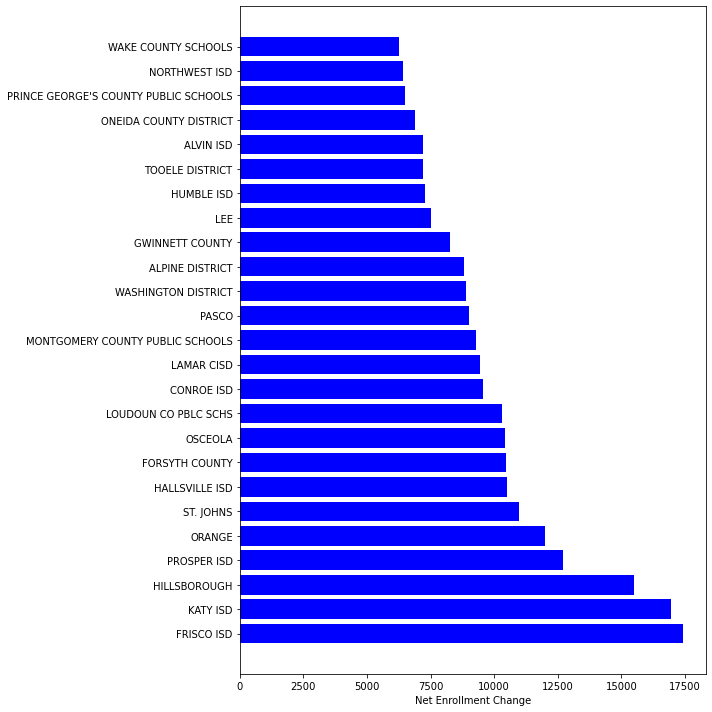

In [107]:
#top 25 districts with net enrollment growth
fig, ax = plt.subplots(figsize=(8, 8))
plt.barh(top25g['Agency Name'], top25g['Net Enrollment Change'], color='blue')
plt.xlabel('Net Enrollment Change')
plt.tight_layout()
plt.show();

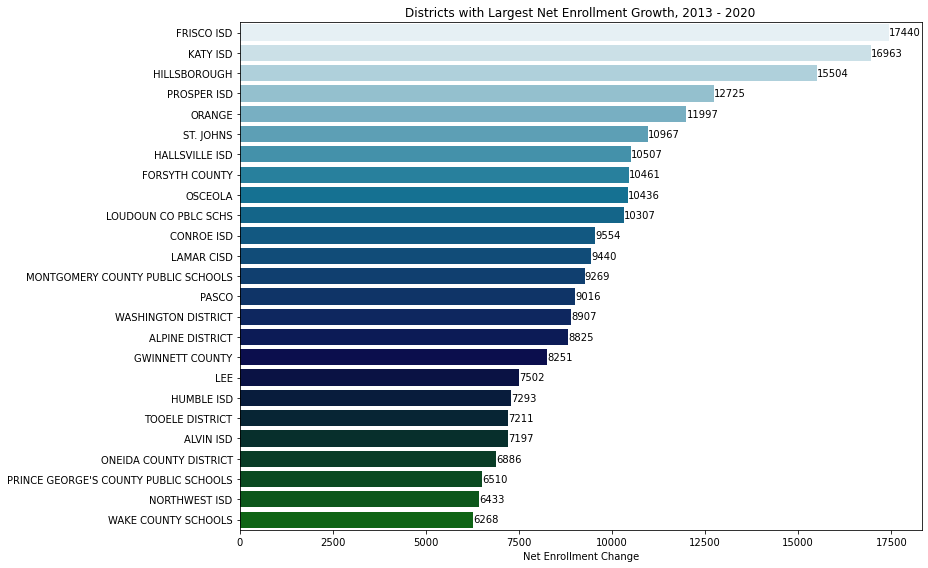

In [130]:
#top 25 districts with net enrollment growth, seaborn
fig, ax = plt.subplots(figsize=(13, 8))
ax = sns.barplot(x='Net Enrollment Change', y='Agency Name',
            data=top25g,
           palette='ocean_r')
ax.bar_label(ax.containers[0])
plt.xlabel('Net Enrollment Change')
plt.ylabel(None)
plt.title('Districts with Largest Net Enrollment Growth, 2013 - 2020')
plt.tight_layout()
plt.show();
#not sure if the bar labels are helpful or distracting at this point

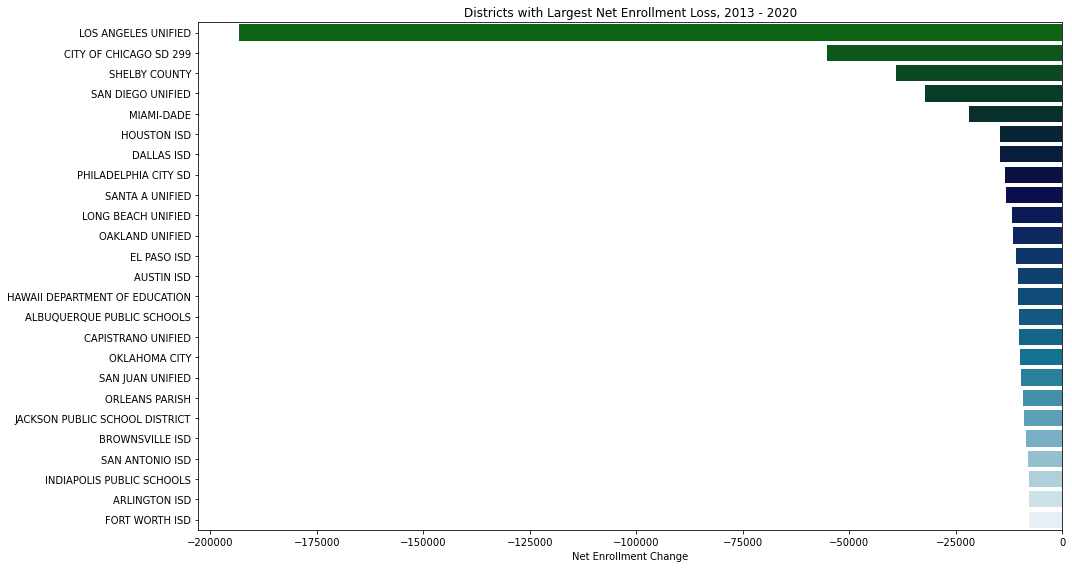

In [136]:
#top 25 districts with net enrollment loss, seaborn
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='Net Enrollment Change', y='Agency Name',
            data=top25l,
           palette='ocean')
#ax.bar_label(ax.containers[0])
plt.xlabel('Net Enrollment Change')
plt.ylabel(None)
plt.title('Districts with Largest Net Enrollment Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

In [137]:
top25combo = pd.concat([top25g, top25l])
top25combo

,Agency Name,State Name,State Abbreviation,NCES ID,County,Student Count,Year,Enrollment Change,Net Enrollment Change,School Count,ZIP Code,District Type,Locale,Start of Year Status,Updated Status,FTE Teachers,Pupil/Teacher Ratio,Total Staff,Census Region,2020 Election Result,2020 Battleground State,Primary Funding Model,Model Name,Notes,Base Amount (Y/N),Base Amount,Base Amount Legal Source,Student Count Method,Student Count Method Source,Special Education Funding Mechanism,Special Education Program Name,Special Education Amount (Dollar amount or weight),Is there a Cap or Minimum threshold in place?,Special Education Funding Description,Special Education Funding Source,English Learner Funding? (Y/N),English Learner Funding Mechanism,English Learner Program Name,English Learner Amount (Dollar amount or weight),ELL Amount Source,At-Risk Funding for Low-Income Students (Y/N),Low-Income Students Funding Mechanism,Low-Income Students Program Name,Low-Income Students Identifier,Low-Income Students Amount (Dollar amount or weight),Low-Income Funding Source,Gifted and Talented Funding? (Y/N),Gifted and Talented Funding Mechanism,Gifted and Talented Program Name,Gifted and Talented Amount (Dollar amount or weight),Gifted Funding Source,Small Size or Isolated Adjustment? (Y/N),Small Size Funding Mechanism,Small Size Program Name,Small Size Amount (Dollar amount or weight),Small Size Identifier,Small Size Identifier Source
91432,FRISCO ISD,TEXAS,TX,4820010,COLLIN COUNTY,46053.0,2013,NaN,17440.0,55.0,75035,1.0,21-Suburb: Large,1-Open,NaN,3052.0,15.0,5410.0,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,$6160 (2020-2023),Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,Multiple student weights,Student-Based Allotments: Special Education,Additional weights range from 1.1 to 5.0 Mains...,No,Different student weights are based on where t...,Tex. Educ. Code Ann. § 48.102,Yes,Multiple student weights,Bilingual Education Allotment,Additional weight of .1 for a student of limit...,Tex. Educ. Code Ann. § 48.105,Yes,Multiple student weights,Compensatory Education Allotment,Multiple - the state has an index for economic...,Provides the following weights in five tiers r...,Tex. Educ. Code Ann. § 48.104,No,NaN,NaN,NaN,NaN,Yes,Multiple student weights,Small and Mid-Sized District Allotment,"For small districts (those with fewer than 1,6...",Number of students,Tex. Educ. Code Ann. § 48.101
92583,KATY ISD,TEXAS,TX,4825170,FORT BEND COUNTY,67213.0,2013,NaN,16963.0,61.0,77494,1.0,21-Suburb: Large,1-Open,NaN,4303.0,16.0,8163.0,South,Republican,Yes,Student-based foundation,Foundation School Program,NaN,Yes,$6160 (2020-2023),Tex. Educ. Code Ann. § 48.051,Attendance average,Tex. Educ. Code Ann. § 48.005,Multiple student weights,Student-Based Allotments: Special Education,Additional weights range from 1.1 to 5.0 Mains...,No,Different student weights are based on where t...,Tex. Educ. Code Ann. § 48.102,Yes,Multiple student weights,Bilingual Education Allotment,Additional weight of .1 for a student of limit...,Tex. Educ. Code Ann. § 48.105,Yes,Multiple student weights,Compensatory Education Allotment,Multiple - the state has an index for economic...,Provides the following weights in five tiers r...,Tex. Educ. Code Ann. § 48.104,No,NaN,NaN,NaN,NaN,Yes,Multiple student weights,Small and Mid-Sized District Allotment,"For small districts (those with fewer than 1,6...",Number of students,Tex. Educ. Code Ann. § 48.101
16489,HILLSBOROUGH,FLORIDA,FL,1200870,HILLSBOROUGH COUNTY,203439.0,2013,NaN,15504.0,310.0,33602,1.0,21-Suburb: Large,1-Open,NaN,14266.0,14.0,26640.0,South,Republican,Yes,Student-based foundation,Florida Education Finance Program,NaN,Yes,"$4,372.91 (2021-22) K-3: additional weight of ...",Fla. Stat. Ann. § 1011.62 S.B. 2500,Membership average,Fla. Stat. Ann. § 1011.62,Multiple student weights,"Florida Education Finance Program, Exceptional...",Support Level IV: 2.648 additional weight Supp...,

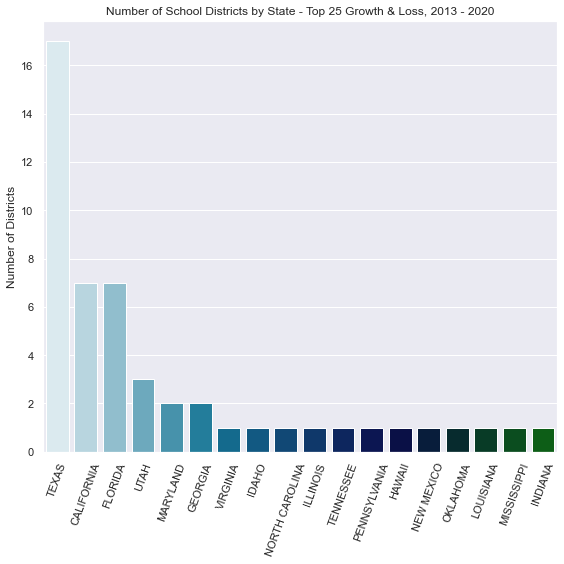

In [143]:
#profiles of top 25 - state
sns.set(rc={"figure.figsize":(8,8)})
state_order=['TEXAS', 'CALIFORNIA', 'FLORIDA', 'UTAH', 'MARYLAND', 'GEORGIA', 'VIRGINIA', 'IDAHO', 'NORTH CAROLINA', 'ILLINOIS', 'TENNESSEE', 'PENNSYLVANIA', 'HAWAII', 'NEW MEXICO', 'OKLAHOMA', 'LOUISIANA', 'MISSISSIPPI', 'INDIANA']
sns.countplot(x='State Name', data=top25combo, order=state_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by State - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

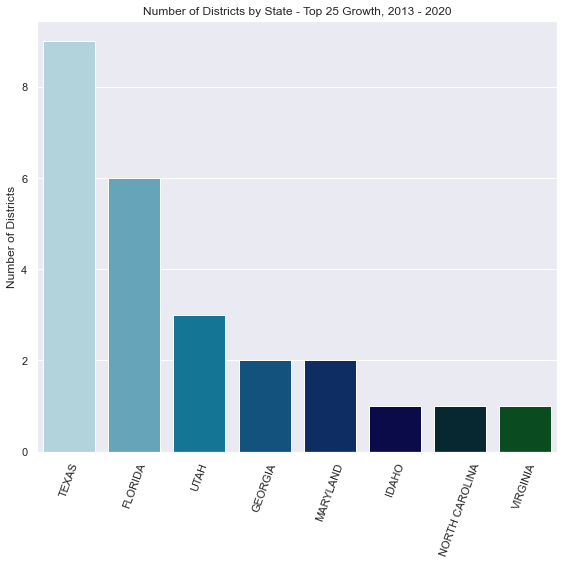

In [144]:
#countplot by state for top 25 enrollment growth
sns.set(rc={"figure.figsize":(8,8)})
state_order=['TEXAS', 'FLORIDA', 'UTAH', 'GEORGIA', 'MARYLAND', 'IDAHO', 'NORTH CAROLINA', 'VIRGINIA']
sns.countplot(x='State Name', data=top25g, order=state_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of Districts by State - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

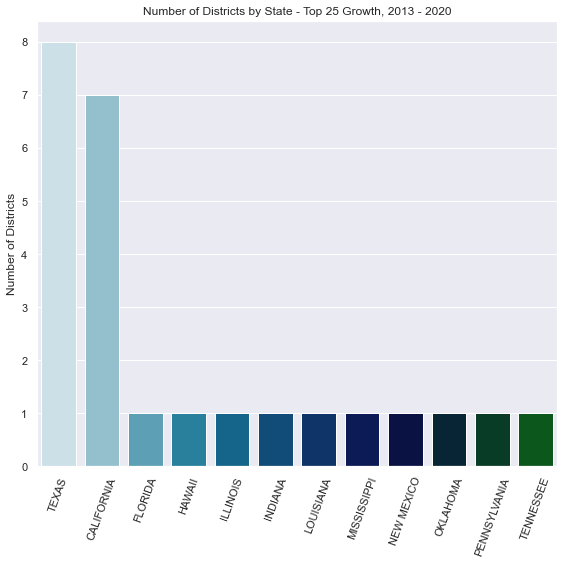

In [147]:
#countplot by state for top 25 enrollment loss
sns.set(rc={"figure.figsize":(8,8)})
state_order=['TEXAS', 'CALIFORNIA', 'FLORIDA', 'HAWAII', 'ILLINOIS', 'INDIANA', 'LOUISIANA', 'MISSISSIPPI', 'NEW MEXICO', 'OKLAHOMA', 'PENNSYLVANIA', 'TENNESSEE']
sns.countplot(x='State Name', data=top25l, order=state_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of Districts by State - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

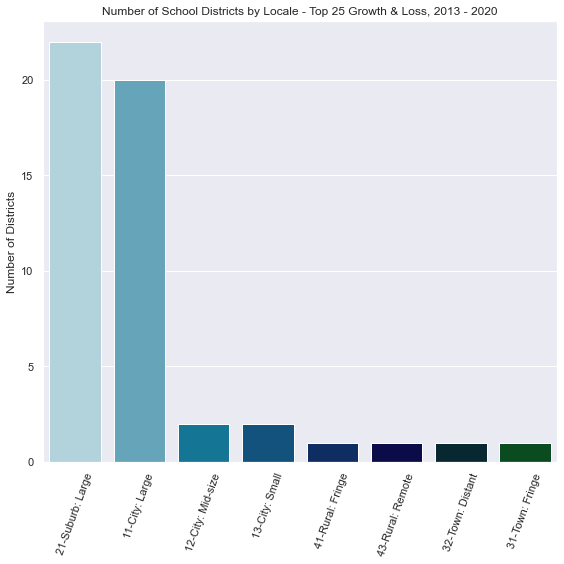

In [151]:
#profiles of top 25 - locale
sns.set(rc={"figure.figsize":(8,8)})
locale_order=['21-Suburb: Large', '11-City: Large', '12-City: Mid-size', '13-City: Small', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Locale', data=top25combo, order=locale_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Locale - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

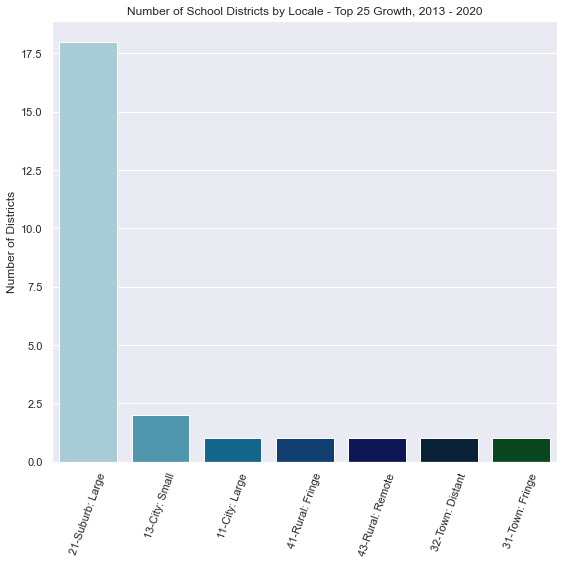

In [154]:
#profiles of top 25 growth - locale
sns.set(rc={"figure.figsize":(8,8)})
locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Locale', data=top25g, order=locale_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Locale - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

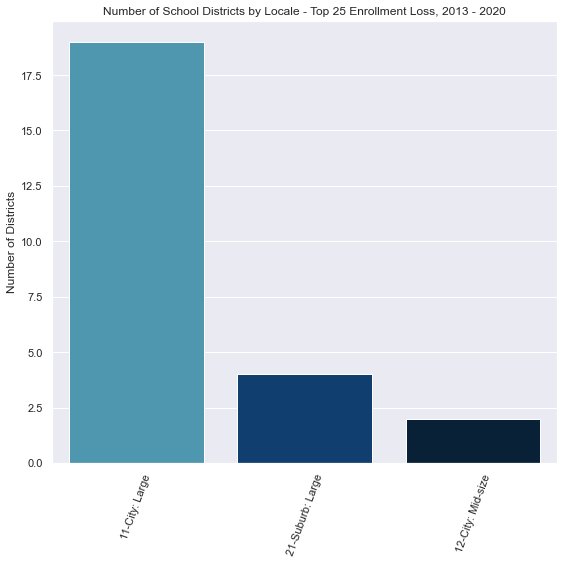

In [155]:
#profiles of top 25 loss - locale
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Locale', data=top25l, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Locale - Top 25 Enrollment Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

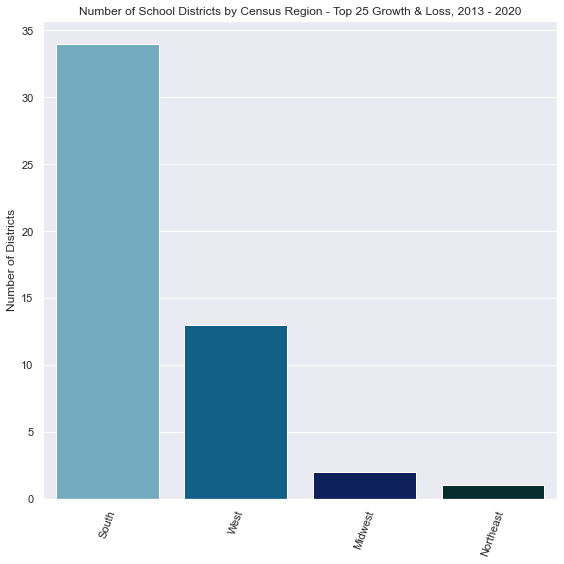

In [156]:
#profiles of top 25 - census region
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '11-City: Large', '12-City: Mid-size', '13-City: Small', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Census Region', data=top25combo, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Census Region - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

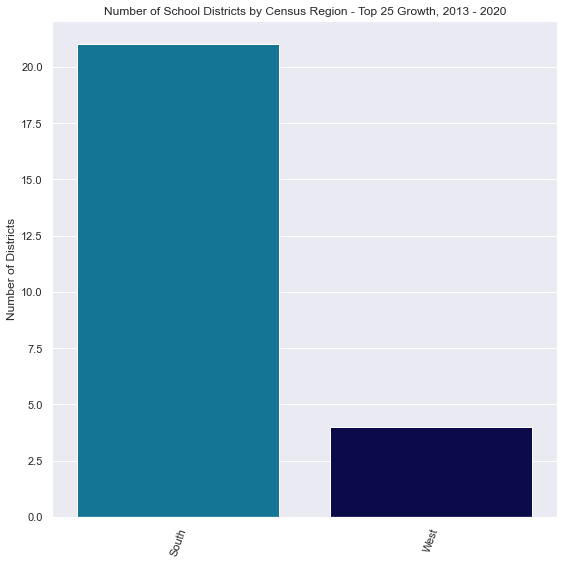

In [157]:
#profiles of top 25 growth - census
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='Census Region', data=top25g, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Census Region - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

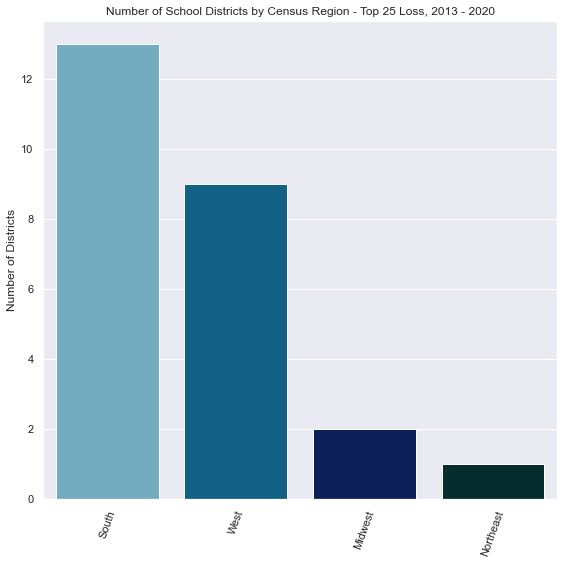

In [159]:
#profiles of top 25 growth - census
sns.set(rc={"figure.figsize":(8,8)})
census_order=['South', 'West', 'Midwest', 'Northeast']
sns.countplot(x='Census Region', data=top25l, order=census_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Census Region - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

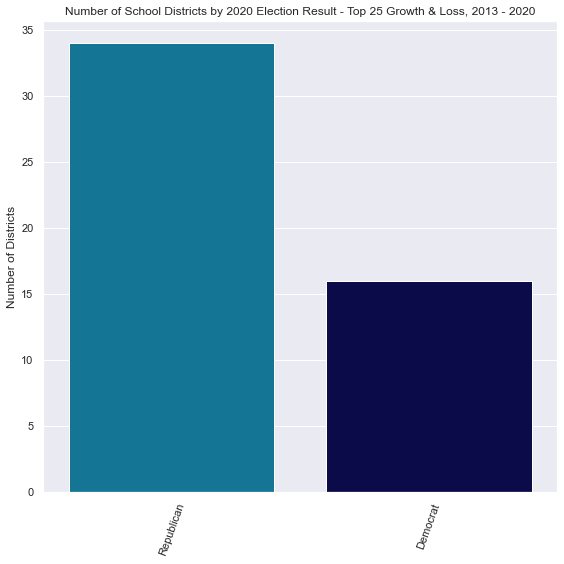

In [161]:
#profiles of top 25 - election result
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '11-City: Large', '12-City: Mid-size', '13-City: Small', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='2020 Election Result', data=top25combo, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by 2020 Election Result - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

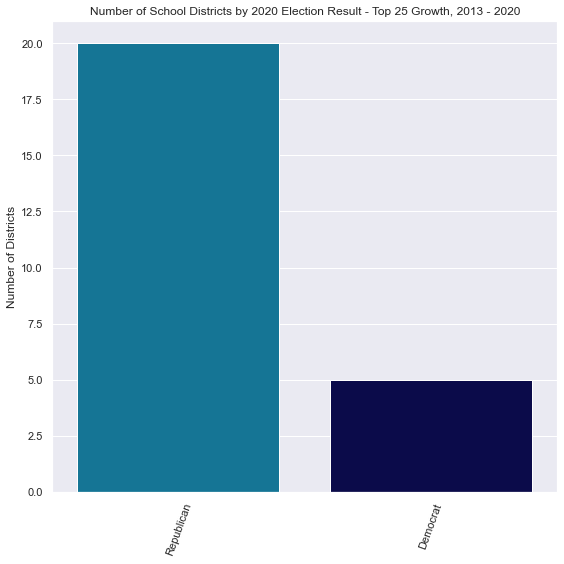

In [162]:
#profiles of top 25 growth - election result
sns.set(rc={"figure.figsize":(8,8)})
#locale_order=['21-Suburb: Large', '13-City: Small', '11-City: Large', '41-Rural: Fringe', '43-Rural: Remote', '32-Town: Distant', '31-Town: Fringe']
sns.countplot(x='2020 Election Result', data=top25g, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by 2020 Election Result - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

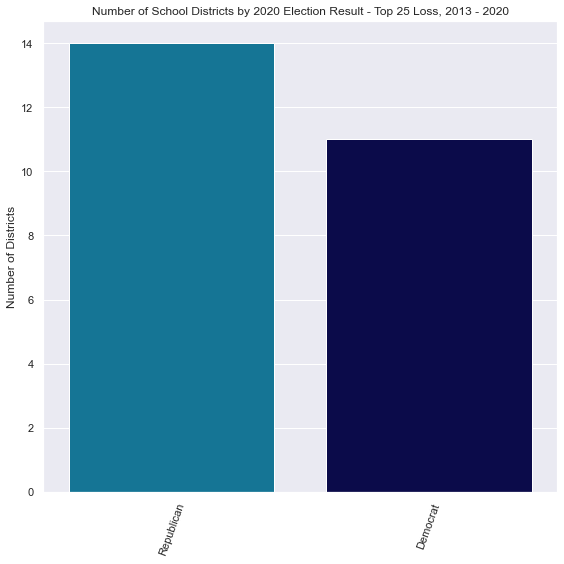

In [165]:
#profiles of top 25 growth - election result
sns.set(rc={"figure.figsize":(8,8)})
result_order=['Republican', 'Democrat']
sns.countplot(x='2020 Election Result', data=top25l, order=result_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by 2020 Election Result - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

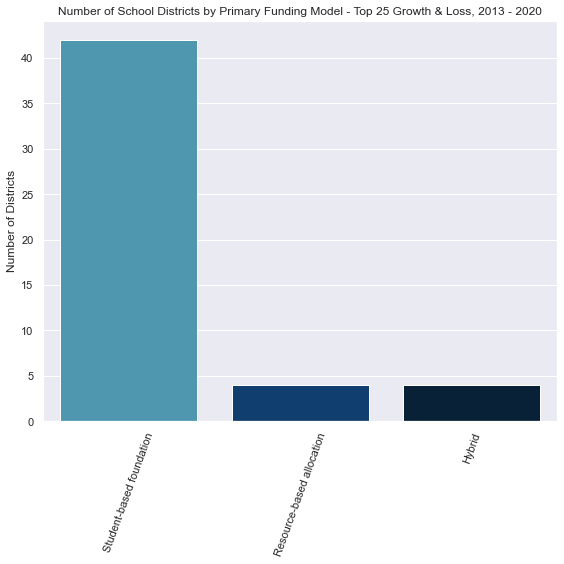

In [169]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Primary Funding Model', data=top25combo, order=funding_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Primary Funding Model - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

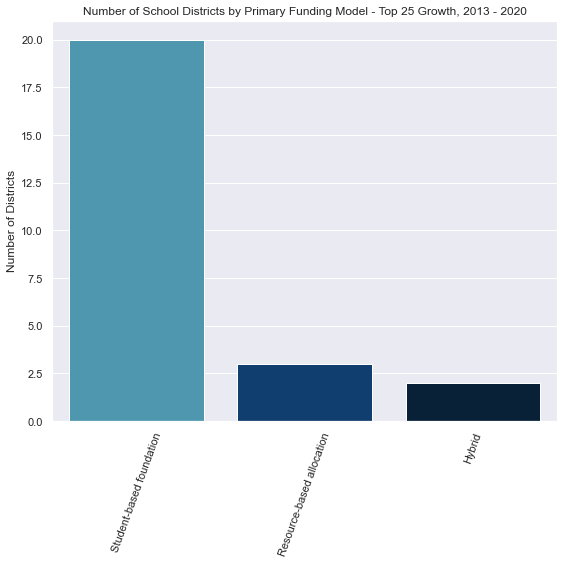

In [168]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Primary Funding Model', data=top25g, order=funding_order, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Primary Funding Model - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

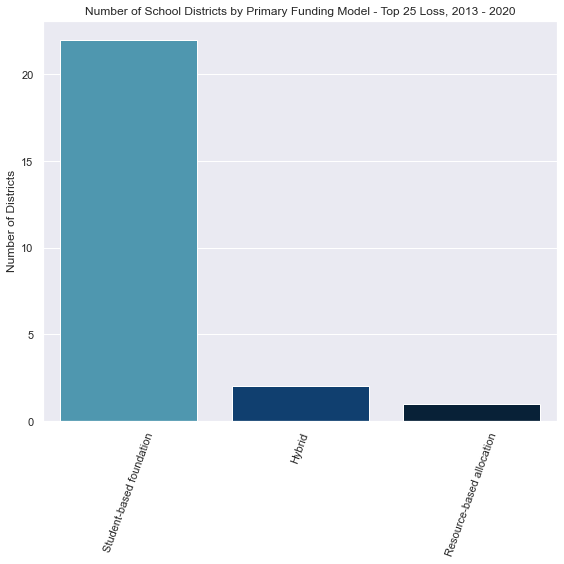

In [170]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Primary Funding Model', data=top25l, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Primary Funding Model - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

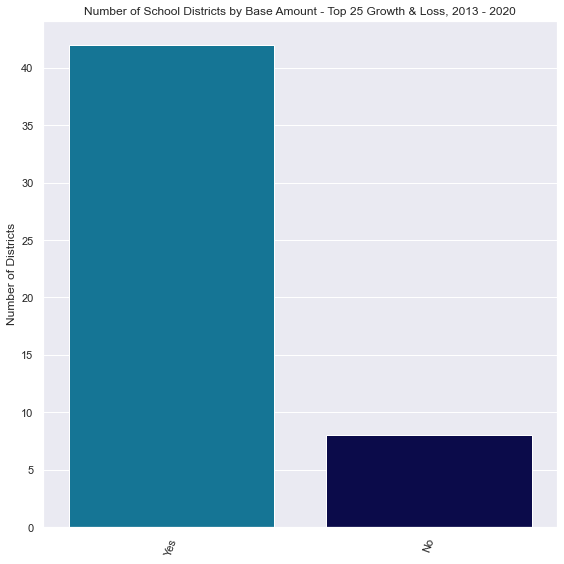

In [172]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Base Amount (Y/N)', data=top25combo, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Base Amount - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

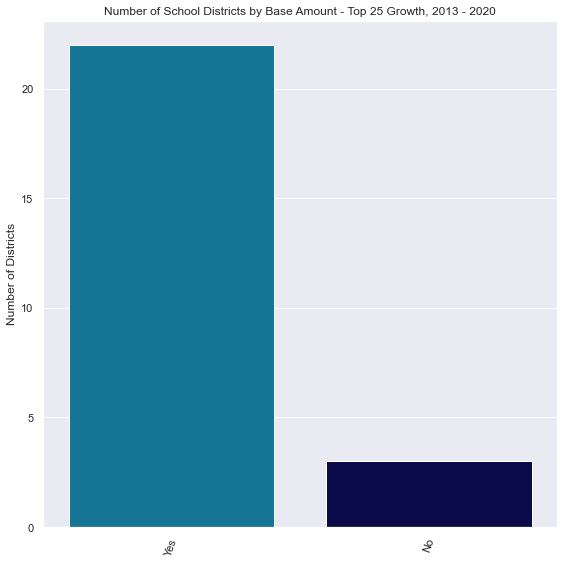

In [173]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Base Amount (Y/N)', data=top25g, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Base Amount - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

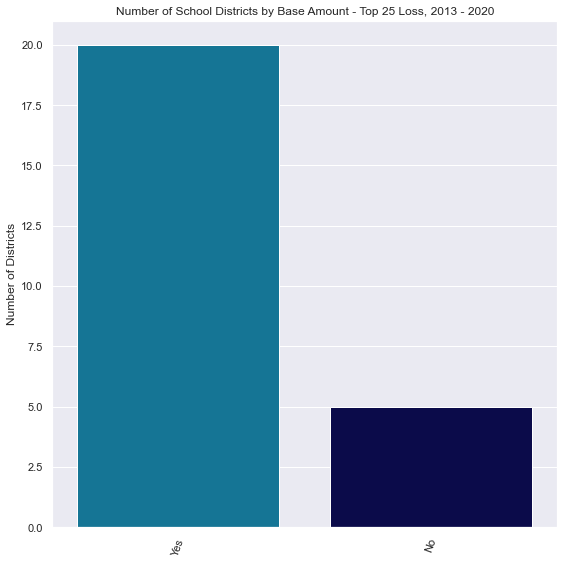

In [178]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.countplot(x='Base Amount (Y/N)', data=top25l, palette='ocean_r')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.xticks(rotation=70)
plt.xlabel(None)
plt.ylabel('Number of Districts')
plt.title('Number of School Districts by Base Amount - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

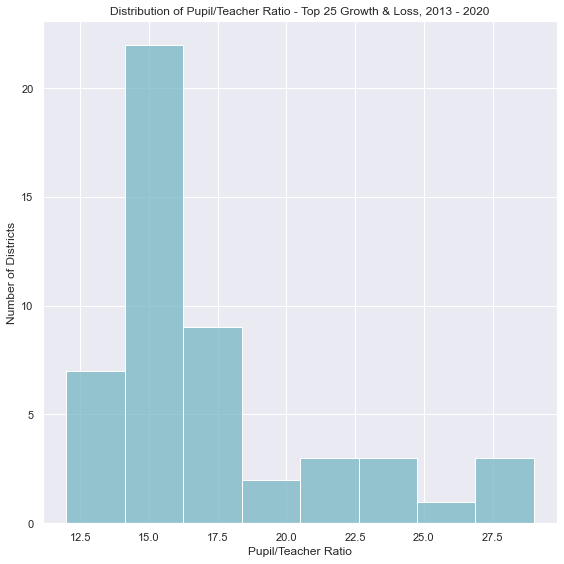

In [180]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Pupil/Teacher Ratio', data=top25combo, bins=8, color='#76b6c4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Pupil/Teacher Ratio')
plt.ylabel('Number of Districts')
plt.title('Distribution of Pupil/Teacher Ratio - Top 25 Growth & Loss, 2013 - 2020')
plt.tight_layout()
plt.show();

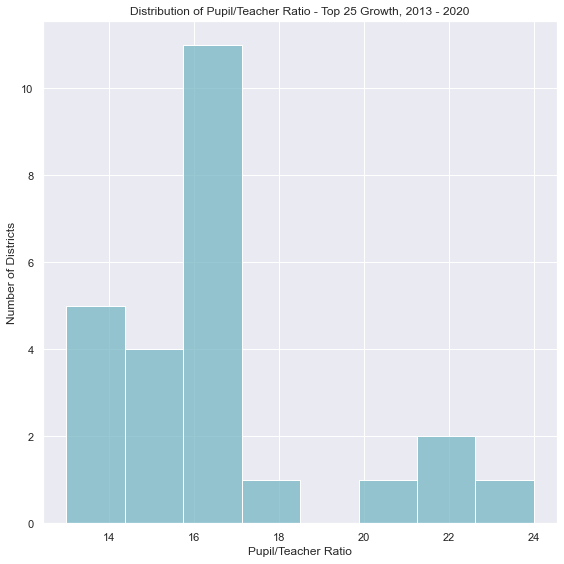

In [181]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Pupil/Teacher Ratio', data=top25g, bins=8, color='#76b6c4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Pupil/Teacher Ratio')
plt.ylabel('Number of Districts')
plt.title('Distribution of Pupil/Teacher Ratio - Top 25 Growth, 2013 - 2020')
plt.tight_layout()
plt.show();

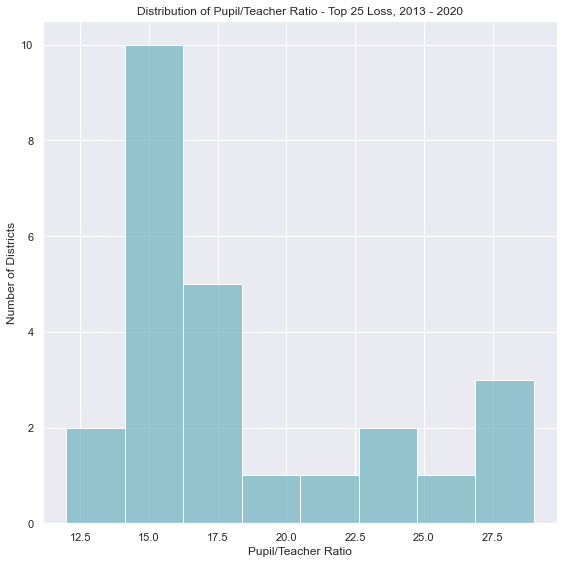

In [182]:
#profiles of top 25 - funding model
sns.set(rc={"figure.figsize":(8,8)})
#funding_order=['Student-based foundation', 'Resource-based allocation', 'Hybrid']
sns.histplot(x='Pupil/Teacher Ratio', data=top25l, bins=8, color='#76b6c4')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
#plt.xticks(rotation=70)
plt.xlabel('Pupil/Teacher Ratio')
plt.ylabel('Number of Districts')
plt.title('Distribution of Pupil/Teacher Ratio - Top 25 Loss, 2013 - 2020')
plt.tight_layout()
plt.show();